# Abusive Language Detector
### Machine Learning Model using classifier with Convolutional Neural Networks

This notebook forms part of the SET11121 / SET11521 / SET11821 - Data Wrangling assignment, to develop and evaluate a abusive language detection model for a given dataset.

The model is a Convolutional Neural Network using Word2Vec as the word embedding layer. 

The CNN architecture chosen is described in more detail in submission - Part B literture.

The notebook contains some source code which has been adapted and modified to meet the needs of model. Source code credit is provided where applicable, and references provided at the end of the notebook. 

The libraries used are NLTK, Gensim, Keras, Numpy, Pandas and a pre-trained Google News corpus (3 billion running words) word vector model containing 3 million 300-dimension English word vectors.

In [9]:
# Import all of the neccesary libraries needed
from __future__ import division, print_function
from gensim import models
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Conv1D, GlobalMaxPooling1D, Embedding
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import os
import collections
import requests
import re
import string
import nltk

In [171]:
# The cell will produce the list of package versions loaded in the notebook. 
# Rationale is to provide important version information, in light of any troubleshooting issues
import pkg_resources
import types

def get_libary_versions():
        requirements = []
        for m in pkg_resources.working_set:
            if m.project_name in imports and m.project_name!="pip":
                requirements.append((m.project_name, m.version))

        for r in requirements:
            print("{}=={}".format(*r))

# Get library versions             
get_libary_versions()

gensim==3.8.1
pandas==0.25.1
numpy==1.16.5
nltk==3.4.5


In [172]:
# Lets import the provided datatset needed for the model evaluation
source_data = pd.read_csv('data/agr_en_train.csv', header = None, delimiter=',')

In [173]:
# Lets add some color to the imported dataset
source_data.columns = ['unique_id','text','aggression_level']

# Display the source data and see some sample output of the data
source_data.head()

unique_id  \
0  facebook_corpus_msr_1723796   
1   facebook_corpus_msr_466073   
2  facebook_corpus_msr_1493901   
3   facebook_corpus_msr_405512   
4  facebook_corpus_msr_1521685   

                                                text aggression_level  
0  Well said sonu..you have courage to stand agai...              OAG  
1  Most of Private Banks ATM's Like HDFC, ICICI e...              NAG  
2     Now question is, Pakistan will adhere to this?              OAG  
3  Pakistan is comprised of fake muslims who does...              OAG  
4  ??we r against cow slaughter,so of course it w...              NAG

In [174]:
# Based on the README of the provided dataset:
#    The file contain 3 columns in the following format
#         unique_id,text,aggression-level
#    There are three aggression levels:
#       'Overtly Aggressive' denoted as OAG
#       'Covertly Aggressive' denoted as CAG
#       'Non-aggressive' denoted as NAG


# Lets validate that the data only contains the above mentioned values
source_data.aggression_level.unique()

array(['OAG', 'NAG', 'CAG'], dtype=object)

In [175]:
# Lets validate the shape of the dataset
source_data.shape

(12000, 3)

In [176]:
# Count the number of records in the imported dataset 
source_data.count()

unique_id           12000
text                12000
aggression_level    12000
dtype: int64

In [177]:
# This code will create a new list called lable_al and based on the value in the aggression_level column will assign a 
# numeric value to the aggregation value. The logic being that having a column with a numeric value for the aggregation level 
# will be faster to execute and train. 

# The below numeric assignments to the respective aggregation levels.
#   'Overtly Aggressive’ denoted as OAG = 3
#   ‘Covertly Aggressive’ denoted as CAG = 2
#   ‘Non-aggressive’ denoted as NAG = 1

label_al = []
OAG = []
CAG = []
NAG = []

# Loop through the data and append the source_data dataframe with the aggregation levels indicator columns.
for al in source_data.aggression_level:
    if al == 'OAG':
        label_al.append(3)
        OAG.append(1)
        CAG.append(0)
        NAG.append(0)
    elif al == 'CAG':
        label_al.append(2)
        OAG.append(0)
        CAG.append(1)
        NAG.append(0)
    elif al == 'NAG':
        label_al.append(1)
        OAG.append(0)
        CAG.append(0)
        NAG.append(1)

In [178]:
# This code will append the above lists to the source_data dataframe
source_data['agression_level_indicator']= label_al
source_data['OAG']= OAG
source_data['CAG']= CAG
source_data['NAG']= NAG

In [179]:
source_data.head(2000)

unique_id  \
0     facebook_corpus_msr_1723796   
1      facebook_corpus_msr_466073   
2     facebook_corpus_msr_1493901   
3      facebook_corpus_msr_405512   
4     facebook_corpus_msr_1521685   
...                           ...   
1995  facebook_corpus_msr_1972711   
1996   facebook_corpus_msr_434118   
1997   facebook_corpus_msr_325017   
1998   facebook_corpus_msr_473601   
1999  facebook_corpus_msr_2383837   

                                                   text aggression_level  \
0     Well said sonu..you have courage to stand agai...              OAG   
1     Most of Private Banks ATM's Like HDFC, ICICI e...              NAG   
2        Now question is, Pakistan will adhere to this?              OAG   
3     Pakistan is comprised of fake muslims who does...              OAG   
4     ??we r against cow slaughter,so of course it w...              NAG   
...                                                 ...              ...   
1995  All members will give a vote of thanks to Shri...              CAG   
1996  nothing can win you ,unless you are not defeat...              NAG   
1997  Only narrow minded ultra religious people can ...              OAG   
1998  what is the need of 2000 Rs notes if you reall...              NAG   
1999                       Dr. CHAIWALA will be your CM              CAG   

      agression_level_indicator  OAG  CAG  NAG  
0                             3    1    0    0  
1                             1    0    0    1  
2                             3    1    0    0  
3                             3    1    0    0  
4                             1    0    0    1  
...                         ...  ...  ...  ...  
1995                          2    0    1    0  
1996                          1    0    0    1  
1997                          3    1    0    0  
1998                          1    0    0    1  
1999                          2    0    1    0  

[2000 rows x 7 columns]

In [180]:
# The next step is to tokenize the words. 
# The NLTK library was choosen due to the ease of use and the wealth of tutorials and information avaliable.
# It will also be easier to remove any stop words or punctuation in the dataset using NTLK corpus of data. 
# This section of code was adapted from authors - Arshad, Saad. (2019, September 20). and Yoon, Kim. (2018, Febuary 15).

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [181]:
# Function to remove any punctuation in the text
def remove_punctuation(text):
    text_nopunct = ''
    text_nopunct = re.sub('['+string.punctuation+']', '', text)
    return text_nopunct

# Apply a lamdba function to remove the punctuation in the text body, the intention is to tokenize a dataset that is 
# removed of any punctuation and stop words, so that the performance of the model will be improved.  
source_data['Text_Clean'] = source_data['text'].apply(lambda x: remove_punctuation(x))

In [182]:
source_data.head()

unique_id  \
0  facebook_corpus_msr_1723796   
1   facebook_corpus_msr_466073   
2  facebook_corpus_msr_1493901   
3   facebook_corpus_msr_405512   
4  facebook_corpus_msr_1521685   

                                                text aggression_level  \
0  Well said sonu..you have courage to stand agai...              OAG   
1  Most of Private Banks ATM's Like HDFC, ICICI e...              NAG   
2     Now question is, Pakistan will adhere to this?              OAG   
3  Pakistan is comprised of fake muslims who does...              OAG   
4  ??we r against cow slaughter,so of course it w...              NAG   

   agression_level_indicator  OAG  CAG  NAG  \
0                          3    1    0    0   
1                          1    0    0    1   
2                          3    1    0    0   
3                          3    1    0    0   
4                          1    0    0    1   

                                          Text_Clean  
0  Well said sonuyou have courage to stand agains...  
1  Most of Private Banks ATMs Like HDFC ICICI etc...  
2       Now question is Pakistan will adhere to this  
3  Pakistan is comprised of fake muslims who does...  
4  we r against cow slaughterso of course it will...

In [183]:
# The next step is to tokenize the comments by using NLTK’s word_tokenize. 
# The expectation is passing 'Well said sonu you have courage to stand against dadagiri of Muslims' to word_tokenize
# The output should be ['Well','said','sonu','you','have','courage','to','stand','against','dadagiri','of','Muslims']. 

from nltk import word_tokenize, WordNetLemmatizer
tokens = [word_tokenize(sen) for sen in source_data.Text_Clean] 

In [184]:
# Show the contents of tokens dataframe and confirm if the word_tokenize worked as expected
tokens[:1] 

[['Well',
  'said',
  'sonuyou',
  'have',
  'courage',
  'to',
  'stand',
  'against',
  'dadagiri',
  'of',
  'Muslims']]

In [185]:
# We want to lowercase the dataset to eliminate any potential issues. There is a possibility that we lose context
# by doing this, for example: If the text is all upper case, it could imply shouting, or another possible context.
# This section of code was adapted from authors - Arshad, Saad. (2019, September 20). and Yoon, Kim. (2018, Febuary 15).

def lowercase_token(tokens): 
    return [w.lower() for w in tokens]    
    
# Make the dataset all lowercase   
lower_tokens = [lowercase_token(token) for token in tokens] 

In [186]:
lower_tokens[:1]

[['well',
  'said',
  'sonuyou',
  'have',
  'courage',
  'to',
  'stand',
  'against',
  'dadagiri',
  'of',
  'muslims']]

In [187]:
# We want to remove any stop words from the text, and by using NTLK, we can achieve that fairly easily
# This section of code was adapted from authors - Arshad, Saad. (2019, September 20).

from nltk.corpus import stopwords

# Build a list of stop words, so that we can remove it from the data
stoplist = stopwords.words('english')

In [188]:
stoplist[:20]

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his']

In [189]:
# Build a function to iterate through the dataset to remove any stop words
def remove_stop_words(tokens): 
    return [word for word in tokens if word not in stoplist]

In [190]:
# Up until the step, the text has undergone the following transformations
# 1. Removed the punctuation from the text, i.e [Well said sonu..you have courage to stand against dadagiri of Muslims]
#    Became - 'Well said sonu you have courage to stand against dadagiri of Muslims'
# 2. Made the text all lowercase, i.e [Well said sonu you have courage to stand against dadagiri of Muslims]
#    Became - 'well said sonu you have courage to stand against dadagiri of muslims'
# 3. Now we want to further cleanse the datset by removing the stopwords
#    i.e 'well said sonu you have courage to stand against dadagiri of muslims' should be transformed to 
#    'well', 'said', 'sonuyou', 'courage', 'stand', 'dadagiri', 'muslims'
# The logic and rationale being that it will improve the performance of the model becuase of the removal of stop words

filtered_words = [remove_stop_words(sen) for sen in lower_tokens] 

In [191]:
# Review and confirm if the function worked as expected
filtered_words[:1]

[['well', 'said', 'sonuyou', 'courage', 'stand', 'dadagiri', 'muslims']]

In [192]:
# Now we create a clean dataset without punctuation and stopwords
result = [' '.join(sen) for sen in filtered_words] 

In [193]:
result[:2]

['well said sonuyou courage stand dadagiri muslims',
 'private banks atms like hdfc icici etc cash public sector banks atm working']

In [194]:
# Append the source_data dataframe with the cleansed text 
source_data['Text_Final'] = result
source_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 9 columns):
unique_id                    12000 non-null object
text                         12000 non-null object
aggression_level             12000 non-null object
agression_level_indicator    12000 non-null int64
OAG                          12000 non-null int64
CAG                          12000 non-null int64
NAG                          12000 non-null int64
Text_Clean                   12000 non-null object
Text_Final                   12000 non-null object
dtypes: int64(4), object(5)
memory usage: 843.9+ KB


In [195]:
# Append the source_data dataframe with the clean tokenized data 
source_data['tokens'] = filtered_words

In [196]:
# Build a new data frame with the clean text and transposed data 
# Data Frame Structure (Schema)
#  +- Text_Final
#  +- tokens
#  +- aggression_level
#  +- OAG
#  +- CAG
#  +- NAG
input_source_data = source_data[['Text_Final', 'tokens', 'aggression_level', 'agression_level_indicator', 'CAG', 'NAG', 'OAG']]

In [197]:
input_source_data.head(100)

Text_Final  \
0    well said sonuyou courage stand dadagiri muslims   
1   private banks atms like hdfc icici etc cash pu...   
2                            question pakistan adhere   
3   pakistan comprised fake muslims know meaning u...   
4   r cow slaughterso course stop leather manufact...   
..                                                ...   
95  one defeat modi bihari people might saddened d...   
96     anuj porinju view markets make new high budget   
97  called seculars ruled nation 60yrs didnt even ...   
98                                      salute friend   
99                   puppet came mcd election chutiya   

                                               tokens aggression_level  \
0   [well, said, sonuyou, courage, stand, dadagiri...              OAG   
1   [private, banks, atms, like, hdfc, icici, etc,...              NAG   
2                        [question, pakistan, adhere]              OAG   
3   [pakistan, comprised, fake, muslims, know, mea...              OAG   
4   [r, cow, slaughterso, course, stop, leather, m...              NAG   
..                                                ...              ...   
95  [one, defeat, modi, bihari, people, might, sad...              CAG   
96  [anuj, porinju, view, markets, make, new, high...              NAG   
97  [called, seculars, ruled, nation, 60yrs, didnt...              OAG   
98                                   [salute, friend]              OAG   
99             [puppet, came, mcd, election, chutiya]              CAG   

    agression_level_indicator  CAG  NAG  OAG  
0                           3    0    0    1  
1                           1    0    1    0  
2                           3    0    0    1  
3                           3    0    0    1  
4                           1    0    1    0  
..                        ...  ...  ...  ...  
95                          2    1    0    0  
96                          1    0    1    0  
97                          3    0    0    1  
98                          3    0    0    1  
99                          2    1    0    0  

[100 rows x 7 columns]

In [198]:
# Check the shapre and information on the dataframe which will be passed to the model
input_source_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 7 columns):
Text_Final                   12000 non-null object
tokens                       12000 non-null object
aggression_level             12000 non-null object
agression_level_indicator    12000 non-null int64
CAG                          12000 non-null int64
NAG                          12000 non-null int64
OAG                          12000 non-null int64
dtypes: int64(4), object(3)
memory usage: 656.4+ KB


### Split data into test and train

In [199]:
# We need to create training, and testing datasets, we will use the train_test_split function from Keras to achive this
source_data_train, source_data_test = train_test_split(input_source_data, test_size=0.10, random_state=42)

In [200]:
# Build a list with all of the tokenized words from the training dataset 
all_training_words = [word for tokens in source_data_train["tokens"] for word in tokens]
# Build a list containing the length of the tokenized words
training_sentence_lengths = [len(tokens) for tokens in source_data_train["tokens"]]

In [201]:
# Validate that the length is correct
print(training_sentence_lengths[:1])
print(source_data_train["tokens"][:1])

[9]
1744    [whatever, rm, honest, needs, make, railways, ...
Name: tokens, dtype: object


In [202]:
# Build a list for the training dataset vocabulary
training_vocabulary = sorted(list(set(all_training_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_training_words), len(training_vocabulary)))
print("Max sentence length is %s" % max(training_sentence_lengths))

156277 words total, with a vocabulary size of 24213
Max sentence length is 666


In [203]:
all_test_words = [word for tokens in source_data_test["tokens"] for word in tokens]
test_sentence_lengths = [len(tokens) for tokens in source_data_test["tokens"]]
testing_vocabulary = sorted(list(set(all_test_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_test_words), len(testing_vocabulary)))
print("Max sentence length is %s" % max(test_sentence_lengths))

16086 words total, with a vocabulary size of 5777
Max sentence length is 277


In [11]:
# This step will load the Google News Word2Vec model. 
# The word2vec model is a pre-trained Google News corpus (3 billion running words) word vector model 
# containing 3 million 300-dimension English word vectors.
# Official Link - https://github.com/mmihaltz/word2vec-GoogleNews-vectors 
# This step may take some time, depending on your computer specifications

# Load the Word2Vec model

word2vec_path = 'data/GoogleNews-vectors-negative300.bin.gz'

def download_word2vec_model(word2vec_path):
    if not os.path.isfile(word2vec_path):
        print('word2vec Google News model doesnt exist, it will download it automatically')
        url = "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
        word2vec_google_dataset = requests.get(url)
        open('data/GoogleNews-vectors-negative300.bin.gz', 'wb').write(word2vec_google_dataset.content)
        
download_word2vec_model(word2vec_path)

word2vec = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [205]:
word2vec

In [206]:
# This function will get return the word embedding from the provided tokens 
# Some of this code was adapted from Gensim Word2Vec Model website tutorials
# https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#sphx-glr-auto-examples-tutorials-run-word2vec-py

def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_comments, generate_missing=False):
    embeddings = clean_comments['tokens'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

# Get Embeddings 

In [207]:
training_embeddings = get_word2vec_embeddings(word2vec, source_data_train, generate_missing=True)

In [208]:
training_embeddings

[array([-7.49240443e-02,  9.75036621e-02,  8.10750350e-02,  9.27395299e-02,
        -4.02560756e-02, -7.61583121e-03,  6.11979179e-02,  2.45768223e-02,
         1.46681041e-01,  1.67575404e-02, -1.15668401e-01, -4.86823171e-02,
         4.97979075e-02,  7.46527761e-02, -1.02077909e-01,  5.51656075e-02,
         3.17993164e-02,  7.63346329e-02,  3.30674909e-02, -4.80058454e-02,
         9.51063335e-02, -3.24367955e-02,  1.25637472e-01,  7.37847239e-02,
        -1.03251142e-02, -4.90459874e-02, -1.48322210e-01,  3.79977748e-02,
         8.40928778e-03, -3.02734375e-02,  2.98394094e-04, -2.11452916e-02,
        -8.21923167e-02, -7.59311244e-02,  1.23935277e-02, -1.04226008e-01,
         4.11648229e-02,  5.64507395e-02,  1.26315653e-01,  6.71251118e-02,
         5.14865443e-02, -6.29764125e-02,  7.47205913e-02,  1.72288679e-02,
        -7.69382063e-03, -1.19664513e-01, -1.04895696e-01,  4.33324166e-02,
        -4.37554270e-02,  9.62999091e-03,  1.05319552e-01,  1.07482910e-01,
         8.1

In [209]:
# Define some constant values which will affect the performance of the models 
MAX_SEQUENCE_LENGTH = 50
EMBEDDING_DIM = 300 

### Tokenize and Pad sequences

In [210]:
# This code block will vectorize the text corpus of cleansed data 
tokenizer = Tokenizer(num_words=len(training_vocabulary), lower=True, char_level=False)
tokenizer.fit_on_texts(source_data_train["Text_Final"].tolist())
# This step will build a list containing the vectorized values in a sequence
training_sequences = tokenizer.texts_to_sequences(source_data_train["Text_Final"].tolist())
train_word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(train_word_index))

Found 24211 unique tokens.


In [211]:
# This code block will pad and make sure that the input shape is consistant
# Each word is assigned an integer and placed a list. As all the training sentences must have same input shape and the 
# the reason why we need to pad the sentences.
#
# Example if we have a sentence “How text to sequence and padding works”. Each word is assigned a number. 
# how = 1, text = 2, to = 3, sequence =4, and = 5, padding = 6, works = 7. After texts_to_sequences is 
# called our sentence will look like [1, 2, 3, 4, 5, 6, 7 ]. If MAX_SEQUENCE_LENGTH = 10, then padding the sentence 
# will look like [0, 0, 0, 1, 2, 3, 4, 5, 6, 7 ]

train_cnn_data = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [212]:
train_cnn_data

array([[    0,     0,     0, ...,  5690,  1163,  4745],
       [    0,     0,     0, ..., 10185, 10186,  5692],
       [    0,     0,     0, ...,   142, 10188,    10],
       ...,
       [    0,     0,     0, ...,   229,  4784, 24209],
       [    0,     0,     0, ...,   693, 24210,  1281],
       [    0,     0,     0, ..., 24211,   311,    28]])

In [213]:
# This code block will get the embeddings from the pre-trained word and phrase vectors from Google News Word2Vec model
# and save them corresponding to the sequence number we assigned to each word. If there is no ebeddings found 
# we save a random vector for that word

train_embedding_weights = np.zeros((len(train_word_index)+1, EMBEDDING_DIM))
for word,index in train_word_index.items():
    train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(train_embedding_weights.shape)

(24212, 300)


In [214]:
test_sequences = tokenizer.texts_to_sequences(source_data_test["Text_Final"].tolist())
test_cnn_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [215]:
test_cnn_data

array([[   0,    0,    0, ..., 9115,    1,  222],
       [   0,    0,    0, ...,   15,    5,  599],
       [   0,    0,    0, ..., 2416, 1986, 4075],
       ...,
       [   0,    0,    0, ..., 1495,  574,   70],
       [   0,    0,    0, ...,  101, 4119,  561],
       [   0,    0,    0, ..., 2874, 5887, 3681]])

### Define CNN

In [216]:
# This function defines the CNN, including the paramters which can be passed to the model 
# This section of code was adapted from authors - Arshad, Saad. (2019, September 20). and Yoon, Kim. (2018, Febuary 15).

def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index):
    
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=False)
    
    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    convs = []
    filter_sizes = [2,3,4,5,6]

    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=300, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = GlobalMaxPooling1D()(l_conv)
        convs.append(l_pool)

    l_merge = concatenate(convs, axis=1)

    x = Dropout(0.1)(l_merge)  
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    preds = Dense(labels_index, activation='sigmoid')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    model.summary()
    return model

In [217]:
label_names = ['OAG', 'CAG', 'NAG'] 

In [218]:
# Append our aggression_level lables to our test and train datasets 
y_train = source_data_train[label_names].values
y_test = source_data_test[label_names].values

In [219]:
x_train = train_cnn_data
y_tr = y_train
x_test = test_cnn_data
y_tst = y_test

In [220]:
x_train.size

540000

In [221]:
y_tr.size

32400

In [222]:
x_test.size

60000

In [223]:
y_tst.size

3600

In [224]:
# Execute the model and get a summary of the model
model = ConvNet(train_embedding_weights, MAX_SEQUENCE_LENGTH, len(train_word_index)+1, EMBEDDING_DIM, 
                len(list(label_names)))

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 50, 300)      7263600     input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 49, 300)      180300      embedding_3[0][0]                
__________________________________________________________________________________________________
conv1d_12 (Conv1D)              (None, 48, 300)      270300      embedding_3[0][0]                
____________________________________________________________________________________________

### Train CNN

In [225]:
# Train our CNN model with the below parameters
num_epochs = 10
batch_size = 100

In [226]:
hist = model.fit(x_train, y_tr, epochs=num_epochs, validation_split=0.1, shuffle=True, batch_size=batch_size)

Train on 9720 samples, validate on 1080 samples
Epoch 1/10
9720/9720 [==============================] - 47s 5ms/step - loss: 0.6021 - acc: 0.6829 - val_loss: 0.5573 - val_acc: 0.7065
Epoch 2/10
9720/9720 [==============================] - 29s 3ms/step - loss: 0.5257 - acc: 0.7291 - val_loss: 0.5568 - val_acc: 0.6954
Epoch 3/10
9720/9720 [==============================] - 28s 3ms/step - loss: 0.4667 - acc: 0.7706 - val_loss: 0.5406 - val_acc: 0.7272
Epoch 4/10
9720/9720 [==============================] - 28s 3ms/step - loss: 0.3839 - acc: 0.8245 - val_loss: 0.5743 - val_acc: 0.7096
Epoch 5/10
9720/9720 [==============================] - 28s 3ms/step - loss: 0.2710 - acc: 0.8896 - val_loss: 0.6363 - val_acc: 0.6969
Epoch 6/10
9720/9720 [==============================] - 29s 3ms/step - loss: 0.1891 - acc: 0.9287 - val_loss: 0.6880 - val_acc: 0.7093
Epoch 7/10
9720/9720 [==============================] - 27s 3ms/step - loss: 0.1234 - acc: 0.9591 - val_loss: 0.8005 - val_acc: 0.6867
Epoch 8

### Test CNN

In [227]:
#predictions = model.predict(test_cnn_data, batch_size=1024, verbose=1)
predictions = model.fit(x_test, y_tst, epochs=num_epochs, validation_split=0.1, shuffle=True, batch_size=batch_size)


Train on 1080 samples, validate on 120 samples
Epoch 1/10
1080/1080 [==============================] - 3s 3ms/step - loss: 0.6752 - acc: 0.7093 - val_loss: 0.5415 - val_acc: 0.7139
Epoch 2/10
1080/1080 [==============================] - 3s 3ms/step - loss: 0.4200 - acc: 0.8025 - val_loss: 0.5718 - val_acc: 0.7139
Epoch 3/10
1080/1080 [==============================] - 3s 3ms/step - loss: 0.3220 - acc: 0.8574 - val_loss: 0.5990 - val_acc: 0.7028
Epoch 4/10
1080/1080 [==============================] - 3s 3ms/step - loss: 0.2199 - acc: 0.9093 - val_loss: 0.6647 - val_acc: 0.7139
Epoch 5/10
1080/1080 [==============================] - 3s 3ms/step - loss: 0.1264 - acc: 0.9636 - val_loss: 0.7742 - val_acc: 0.7000
Epoch 6/10
1080/1080 [==============================] - 3s 3ms/step - loss: 0.0808 - acc: 0.9778 - val_loss: 0.7791 - val_acc: 0.7028
Epoch 7/10
1080/1080 [==============================] - 3s 3ms/step - loss: 0.0548 - acc: 0.9873 - val_loss: 0.8308 - val_acc: 0.7056
Epoch 8/10
1080

In [228]:
predictions

In [229]:
test_cnn_data

array([[   0,    0,    0, ..., 9115,    1,  222],
       [   0,    0,    0, ...,   15,    5,  599],
       [   0,    0,    0, ..., 2416, 1986, 4075],
       ...,
       [   0,    0,    0, ..., 1495,  574,   70],
       [   0,    0,    0, ...,  101, 4119,  561],
       [   0,    0,    0, ..., 2874, 5887, 3681]])

In [230]:
source_data_test.head()

Text_Final  \
1935  25lkh cr gdp loss every day nationwide india g...   
6494  brothers per pakistan news dawn attack army si...   
1720  अरे कुछ तो करो खाली हिजड़े की तरह ताली बजाते र...   
9120  pity still dont see fraud ak doesnt hold portf...   
360   surgical strike pakistan indian forces enter p...   

                                                 tokens aggression_level  \
1935  [25lkh, cr, gdp, loss, every, day, nationwide,...              NAG   
6494  [brothers, per, pakistan, news, dawn, attack, ...              NAG   
1720  [अरे, कुछ, तो, करो, खाली, हिजड़े, की, तरह, ताल...              OAG   
9120  [pity, still, dont, see, fraud, ak, doesnt, ho...              NAG   
360   [surgical, strike, pakistan, indian, forces, e...              NAG   

      agression_level_indicator  CAG  NAG  OAG  
1935                          1    0    1    0  
6494                          1    0    1    0  
1720                          3    0    0    1  
9120                          1    0    1    0  
360                           1    0    1    0

In [231]:
source_data_test.aggression_level.value_counts()

NAG    511
CAG    450
OAG    239
Name: aggression_level, dtype: int64

In [232]:
loss, accuracy = model.evaluate(x_train, y_tr, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_test, y_tst, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9218
Testing Accuracy:  0.9661


In [233]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(training):
    acc = training.history['acc']
    val_acc = training.history['val_acc']
    loss = training.history['loss']
    val_loss = training.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 8))
    plt.subplot(1, 2, 2)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


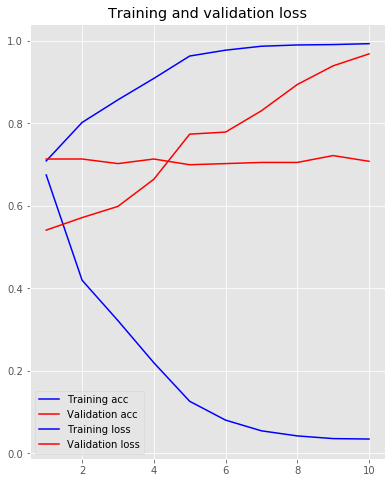

In [234]:
plot_history(predictions)

## References 
Arshad, Saad. (2019, September 20). Sentiment Analysis using Convolution Neural Networks(CNN) and Google News Word2Vec : https://github.com/saadarshad102/Sentiment-Analysis-CNN

Yoon, Kim. (2018, Febuary 15). CNN - Yoon Kim's model and Google's Word2Vec model : https://www.kaggle.com/umbertogriffo/cnn-yoon-kim-s-model-and-google-s-word2vec-model

Arumugam, R., & Shanmugamani, R. Hands-On Natural Language Processing with Python, Packt
https://learning.oreilly.com/library/view/hands-on-natural-language/9781789139495/d8e876e8-25da-4e69-b1d0-e9a017aba93d.xhtml

Arshad, Saad. (2019, September 20). Sentiment Analysis / Text Classification Using CNN (Convolutional Neural Network) from https://towardsdatascience.com: https://towardsdatascience.com/cnn-sentiment-analysis-1d16b7c5a0e7

Janakiev, N. (n.d.). Practical Text Classification With Python and Keras from https://realpython.com/:
https://realpython.com/python-keras-text-classification/

Britz, D. (2015,December 11).Implementing a CNN for Text Classification in TensorFlow from http://www.wildml.com:
http://www.wildml.com/2015/12/implementing-a-cnn-for-text-classification-in-tensorflow/

